# Principal Components Regression

In this chapter we will use principal components regression PCR to predict SPY returns from changes in various VIX indexes.

The underlying idea behind PCR is that often a small number of principal components can sufficiently explain most of the variability in the data, as well as the predictors' relationship with the response. When utilizing PCR, we are tacitly assuming that the directions in which the predictors show the most variation are the directions that are most associated with the label.  While this assumption is not guaranteed, it is reasonable enough that PCR can sometimes yield performance improvements over plain linear regression, or regularized regressions like lasso and ridge.

## Importing Packages

Let's begin by importing the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

### Various VIX Indices

Next, we give a brief discussion of the data we will be analyzing.

The VIX volatility index is published by the CBOE and is a measure of 30-day implied volatility for the S&P 500 index.  Using that same methodology, the CBOE publishes other volatility measures on other stock indices and ETFs, such as the Russell 2000 and EWZ.  Most of the CBOE volatility measures have a 30-day tenor, meaning they are calculated using options that have approximately 30 days to maturity.

There are, however, several CBOE volatility indices with different tenors.  For the S&P 500, in addition to the standard 30-day VIX, there are indices with the following tenors: 9-day, 3-month, 6-month, and 1-year.  The analysis in this chapter is going to involve four of these different S&P 500 VIX tenors.

## Reading-In Data

Let's read-in our data set into a variable called `df_vix`.  The daily SPY return is given in the column called `spy_ret`.

In [ ]:
df_vix = pd.read_csv('vix_knn.csv')
df_vix.dropna(inplace=True) #removing the first row of NaNs
df_vix.head()

,trade_date,vix_009,vix_030,vix_090,vix_180,spy_ret
1,2011-01-04,0.02,-0.23,-0.01,-0.21,-0.000551
2,2011-01-05,-0.49,-0.36,-0.56,-0.41,0.005198
3,2011-01-06,0.14,0.38,0.30,0.09,-0.001959
4,2011-01-07,-0.70,-0.26,-0.06,0.05,-0.001962
5,2011-01-10,0.80,0.40,0.19,0.01,-0.001259


And now let's separate our feature and our labels in preparation for fitting our regressions.

In [ ]:
df_X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
df_y = df_vix['spy_ret']

## A Visualization Aside: `pairplot()` with **seaborn**

Before jumping into our PCA regressions, let's try the `pairplot()` function in the **seaborn** package. This function is useful for simultaneously visualizing pairwise relationships for several variables.

Let's apply this function to the various VIX indices in our data set.

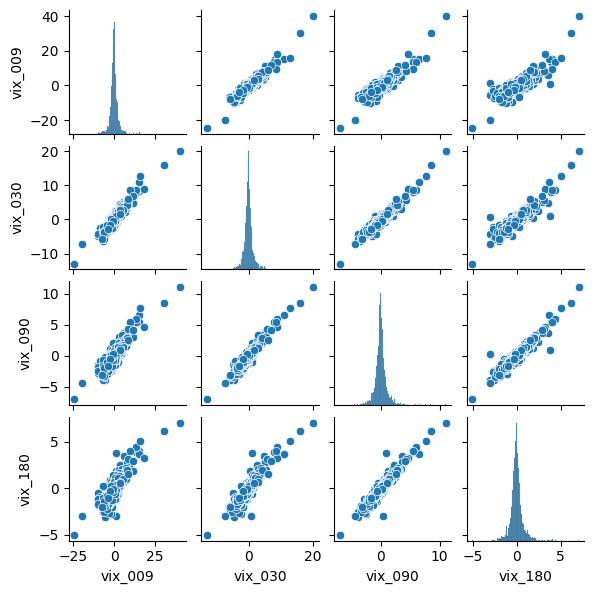

In [ ]:
sns.pairplot(df_X, height=1.5, aspect=1);

As you can see, changes in the VIX indices are highly correlated with one another.

## Principal Components

We now turn our attention to actually calculating the loading vectors (`.components_`) and the scores of the principal components.  We begin by importing the constructor function `PCA()` and instantiating a model object which we will call `pca`.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

Running the `pca.fit_transform()` method of our model does two things:
1. Fits the PCA which calculates the loading vectors and the component scores.
2. Returns an array that contains the component scores.

In [ ]:
pc_scores = pca.fit_transform(df_X)
pd.DataFrame(pc_scores).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,-0.146930,-0.819557,0.393444,-0.700098,0.884020,-1.168302,-0.829475,0.130422,-1.310466,1.820841
1,0.211505,0.359739,-0.286767,-0.276346,0.174504,0.062142,1.050975,0.019997,0.754812,0.993667
2,-0.047278,0.229324,0.109897,-0.077636,0.085444,-0.089474,0.263591,0.116801,0.015106,-0.047431
3,0.174600,-0.087298,0.087328,-0.036313,0.065709,0.006939,-0.048300,-0.032953,-0.062067,-0.013547


Now that our `pca` object is fit, we can examine how much variance is explained by each component.  As you can see, 96% of the variance is explained by the first component.

In [ ]:
pca.explained_variance_ratio_

array([0.96160832, 0.03215176, 0.00460694, 0.00163298])

## Fitting Linear Regressions with Increasing Numbers of Components

Finally, we'll fit linear regressions with increasing numbers of principal components and analyze how the performance of the model changes.  We'll use 10-fold cross-validation root-mean-squared-error as our performance metric.

Let's begin by importing the functions that we need from **sklearn** and instantiating our model object that we will call `lin_reg`.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()

The following `for`-loop iterates through the scores of the principal components and fits a linear regression to cumulative subsets of them.  The first iteration uses the first principal component.  The second iteration uses the first two principal components.  The last iteration uses all the principal components.

In [ ]:
# creating lists to hold results
components_used = []
rmse = []

# performing 10-fold cross validation on and increasing number of principal components
for ix_component in range(1, 5):

    # 10-fold cross-validation
    cv_scores = cross_val_score(estimator=lin_reg,
                                X=pc_scores[:, 0:ix_component],
                                y=df_y,
                                cv=10,
                                scoring='neg_root_mean_squared_error')

    # calculating average rmse
    cv_rmse = -cv_scores.mean()

    # appending to results list
    components_used.append(ix_component)
    rmse.append(cv_rmse)

Let's visualize how our linear regressions perform as we successively add principal components.  Using three principal components performs the best, but just barely.

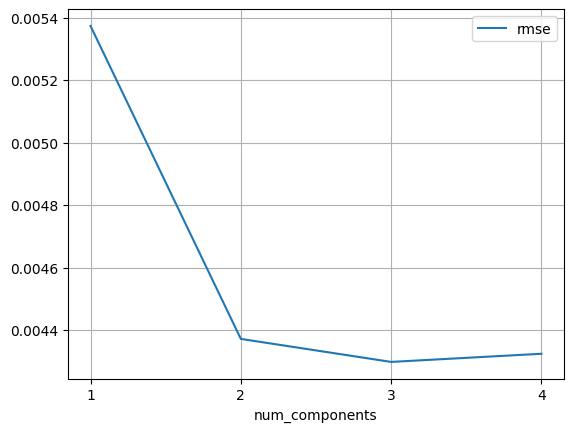

In [ ]:
pd.DataFrame({
    'num_components':components_used,
    'rmse':rmse,
}).plot(x='num_components', y='rmse', grid=True, xticks=range(1, 5));

## References

https://ethanwicker.com/2021-03-14-principal-components-regression-001/